In [1]:
# Imports
import os, requests
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
import gzip

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from IPython.display import display

from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

DEVICE = 'cuda'

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
mice = np.unique(pd.DataFrame(np.array(os.listdir('/content/drive/MyDrive/Mouse_Data/')))[0].apply(lambda x: x[0:15]))
print(mice)

['Slc_mouse461946' 'Slc_mouse462468' 'Slc_mouse462544' 'Slc_mouse464204'
 'Slc_mouse464207' 'Sst_mouse470784' 'Sst_mouse476970' 'Sst_mouse477202'
 'Sst_mouse480753' 'Sst_mouse485688' 'Sst_mouse489056' 'Sst_mouse498972'
 'Vip_mouse467951' 'Vip_mouse467953' 'Vip_mouse467954' 'Vip_mouse489066'
 'Vip_mouse492395']


In [3]:
# Function to load in data from mounted drive on Colab
def load_gzip_arrays(fn, dir = '/content/drive/MyDrive/Mouse_Data/'):
    f = gzip.GzipFile(dir+fn+'_label.npy.gz', "r")
    label_data = np.load(f,allow_pickle=True)
    label_data = pd.DataFrame(label_data,columns=['image_name','is_change','omitted','session_number'])

    f = gzip.GzipFile(dir+fn+'_dffbc.npy.gz', "r")
    dff_bc = np.load(f)

    f = gzip.GzipFile(dir+fn+'_dffstim.npy.gz', "r")
    dff_stim = np.load(f)

    f = gzip.GzipFile(dir+fn+'_dffts.npy.gz', "r")
    dff_ts = np.load(f)

    return label_data, dff_bc, dff_stim, dff_ts

score_test = {}
score_train = {}
score_out = {}

area = 'Sst'
vip_mouse_id = [467951, 467953, 467954, 489066, 492395]
sst_mouse_id = [470784, 476970, 477202, 480753, 485688, 489056, 498972]
slc_mouse_id = [461946, 462468, 462544, 464204, 464207]

mouse_id = sst_mouse_id[4]

if area=='Slc' and mouse_id!=461946:
    fns = os.listdir('/content/drive/MyDrive/Mouse_Data/')
    sessidx = np.array([f'mouse{mouse_id}_sess' in f for f in fns])
    sessfns = np.array(fns)[sessidx]
    def myfun(str):
      return str.split(sep='_')[2][4:]
    vecfun = np.vectorize(myfun)
    sessnums = np.unique(vecfun(sessfns))
    label_data, dff_bc, dff_stim, dff_ts = [], [], [], []
    # Concatenate the sessions together
    for sn in sessnums:
        a, b, c, d = load_gzip_arrays(f'{area}_mouse{mouse_id}_sess{sn}')
        label_data.append(a)
        dff_bc.append(b)
        dff_stim.append(c)
        dff_ts.append(c)
    label_data = pd.concat(label_data)
    dff_bc = np.stack(dff_bc,axis=0)
    dff_stim = np.stack(dff_stim,axis=0)
    dff_ts = np.stack(dff_ts,axis=0)

else: # Vip and Sst (and that one Slc mouse)
    fn = f'{area}_mouse{mouse_id}'
    label_data, dff_bc, dff_stim, dff_ts = load_gzip_arrays(fn)

In [110]:
# Possible subsetting groups
not_omitted = np.logical_not(label_data['omitted'])
familiar = label_data['session_number']<=3
novel = label_data['session_number']>3
passive = np.logical_or(label_data['session_number']==2, label_data['session_number']==5)
active = np.logical_not(passive)
is_change = label_data['is_change']
not_change = np.logical_not(is_change)

# Choose a subset
subset = np.where(np.logical_and.reduce([not_change, not_omitted, familiar]))

subset2 = np.where(np.logical_and.reduce([is_change, not_omitted, familiar]))

len(subset[0])

706

In [114]:
class NetDropout(nn.Module):
  """
  Network Class - 2D with the following structure:
  nn.Linear(1, 300) + leaky_relu(self.dropout1(self.fc1(x))) # First fully connected layer with 0.4 dropout
  nn.Linear(300, 500) + leaky_relu(self.dropout2(self.fc2(x))) # Second fully connected layer with 0.2 dropout
  nn.Linear(500, 1) # Final fully connected layer
  """

  def __init__(self,input_feature_num):
    super(NetDropout, self).__init__()
    self.fc1 = nn.Linear(input_feature_num, 100)
    self.fc2 = nn.Linear(100, 100)
    self.fc3 = nn.Linear(100, 8)
    #self.dropout1 = nn.Dropout(0.5)
    #self.dropout2 = nn.Dropout(0.2)

  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    #x = F.leaky_relu(self.dropout1(self.fc3(x)))
    #x = F.leaky_relu(self.dropout1(self.fc4(x)))
    output = self.fc3(x)
    return output

In [111]:
# Prepare input data (mean firing rates: dff_bc or dff_stim)
X = dff_bc[subset,:].squeeze()
cells_with_data_in_subset = np.where(X.sum(axis=0)!=0)
X = X[:,cells_with_data_in_subset].squeeze()
X = np.nan_to_num(X)
y = label_data.loc[subset,'image_name']
_, y = np.unique(y, return_inverse=True)

In [112]:
# IS CHANGE (subset2)
X2 = dff_bc[subset2,:].squeeze()
#cells_with_data_in_subset = np.where(X.sum(axis=0)!=0)
X2 = X2[:,cells_with_data_in_subset].squeeze()
X2 = np.nan_to_num(X2)
y2 = label_data.loc[subset2,'image_name']
_, y2 = np.unique(y2, return_inverse=True)

X2 = torch.Tensor(X2).to(DEVICE)
y2 = torch.Tensor(y2).to(torch.int64).to(DEVICE)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, stratify=y)
# Initialize
net = NetDropout(X_train.shape[1]).to(DEVICE)
optimizer = optim.Adam(net.parameters(), weight_decay=1e-4, lr=1e-2)
criterion = nn.CrossEntropyLoss()
X_train = torch.Tensor(X_train).to(DEVICE)
#X_val = torch.Tensor(X_val).to(DEVICE)
X_test = torch.Tensor(X_test).to(DEVICE)
y_train = torch.Tensor(y_train).to(torch.int64).to(DEVICE)
#y_val = torch.Tensor(y_val).to(torch.int64).to(DEVICE)
y_test = torch.Tensor(y_test).to(torch.int64).to(DEVICE)

In [116]:
# Train
N_epochs = 2500
training_losses = np.empty(N_epochs)
validation_losses = np.empty(N_epochs)
out_losses = np.empty(N_epochs)
training_accs = np.empty(N_epochs)
validation_accs = np.empty(N_epochs)
out_accs = np.empty(N_epochs)
net.train()
for i in tqdm(range(N_epochs)):
  optimizer.zero_grad()
  yhat_val = net(X_test).to(DEVICE)
  loss_val = criterion(yhat_val, y_test)
  yhat_out = net(X2).to(DEVICE)
  loss_out = criterion(yhat_out, y2)
  yhat_train = net(X_train).to(DEVICE)
  loss = criterion(yhat_train, y_train)
  loss.backward()
  optimizer.step()
  training_losses[i] = loss.item()
  validation_losses[i] = loss_val.item()
  out_losses[i] = loss_out.item()

  _, yhat_train_max = torch.max(yhat_train, 1)
  training_accs[i] = (yhat_train_max == y_train).float().sum()/len(yhat_train_max)

  _, yhat_val_max = torch.max(yhat_val, 1)
  validation_accs[i] = (yhat_val_max == y_test).float().sum()/len(yhat_val_max)

  _, yhat_out_max = torch.max(yhat_out, 1)
  out_accs[i] = (yhat_out_max == y2).float().sum()/len(yhat_out_max)

  # _, yhat_train = torch.max(yhat_train, 1)
  # score_train[mouse_id] = accuracy_score(y_train.to('cpu'), yhat_train)

  0%|          | 0/2500 [00:00<?, ?it/s]

Training score: 1.0
Test score: 0.39436619718309857
Out score: 0.3504286472953494


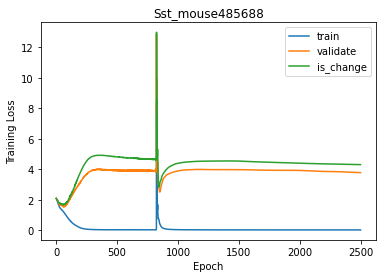

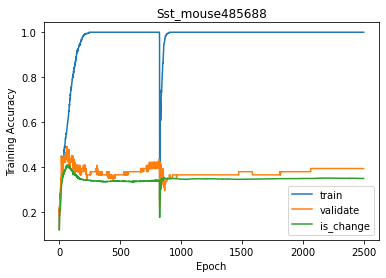

In [117]:
# Evaluate
net.eval()

plt.figure()
plt.title(fn)
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
# lossdf = pd.DataFrame({'training':training_losses,
#               'validation':validation_losses,
#               'is_change':out_losses})
plt.plot(training_losses,label='train')
plt.plot(validation_losses,label='validate')
plt.plot(out_losses,label='is_change')
plt.legend()

plt.figure()
plt.title(fn)
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
# lossdf = pd.DataFrame({'training':training_losses,
#               'validation':validation_losses,
#               'is_change':out_losses})
plt.plot(training_accs,label='train')
plt.plot(validation_accs,label='validate')
plt.plot(out_accs,label='is_change')
plt.legend()

yhat_train = net(X_train).to('cpu')
_, yhat_train = torch.max(yhat_train, 1)
score_train[mouse_id] = accuracy_score(y_train.to('cpu'), yhat_train)
print(f'Training score: {score_train[mouse_id]}')

yhat_test = net(X_test).to('cpu')
_, yhat_test = torch.max(yhat_test, 1)
score_test[mouse_id] = accuracy_score(y_test.to('cpu'), yhat_test)
print(f'Test score: {score_test[mouse_id]}')

yhat_out = net(X2).to('cpu')
_, yhat_out = torch.max(yhat_out, 1)
score_out[mouse_id] = accuracy_score(y2.to('cpu'), yhat_out)
print(f'Out score: {score_out[mouse_id]}')

In [118]:
class ConvNetDropout(nn.Module):
  """
  Network Class - 2D with the following structure:
  nn.Linear(1, 300) + leaky_relu(self.dropout1(self.fc1(x))) # First fully connected layer with 0.4 dropout
  nn.Linear(300, 500) + leaky_relu(self.dropout2(self.fc2(x))) # Second fully connected layer with 0.2 dropout
  nn.Linear(500, 1) # Final fully connected layer
  """

  def __init__(self,input_feature_num):
    super(ConvNetDropout, self).__init__()
    filters_num = 1
    self.conv = nn.Conv1d(input_feature_num,filters_num*input_feature_num,kernel_size=5,padding=2,stride=1)
    self.pool = nn.AdaptiveAvgPool1d(1)
    self.fc1 = nn.Linear(filters_num*input_feature_num, 100)
    self.fc2 = nn.Linear(100, 100)
    self.fc3 = nn.Linear(100, 8)
    #self.dropout1 = nn.Dropout(0.5)
    #self.dropout2 = nn.Dropout(0.2)

  def forward(self, x):
    x0 = self.conv(x)
    #x1 = torch.squeeze(self.pool(x0))
    x1 = torch.amax(x0,2)
    #print(x1.shape)
    x2 = F.leaky_relu(self.fc1(x1))
    x3 = F.leaky_relu(self.fc2(x2))
    #x = F.leaky_relu(self.dropout1(self.fc3(x)))
    #x = F.leaky_relu(self.dropout1(self.fc4(x)))
    output = self.fc3(x3)
    return output

In [119]:
# Prepare input data (mean firing rates: dff_bc or dff_stim)
X = dff_ts[subset,:,:].squeeze()
cells_with_data_in_subset = np.where(X.sum(axis=0).sum(axis=1)!=0)
X = X[:,cells_with_data_in_subset,:].squeeze()
X = np.nan_to_num(X)
y = label_data.loc[subset,'image_name']
_, y = np.unique(y, return_inverse=True)

In [120]:
# IS CHANGE (subset2)
X2 = dff_ts[subset2,:,:].squeeze()
#cells_with_data_in_subset = np.where(X.sum(axis=0)!=0)
X2 = X2[:,cells_with_data_in_subset,:].squeeze()
X2 = np.nan_to_num(X2)
y2 = label_data.loc[subset2,'image_name']
_, y2 = np.unique(y2, return_inverse=True)

X2 = torch.Tensor(X2).to(DEVICE)
y2 = torch.Tensor(y2).to(torch.int64).to(DEVICE)

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, stratify=y)
# Initialize
net = ConvNetDropout(X_train.shape[1]).to(DEVICE)
optimizer = optim.Adam(net.parameters(), weight_decay=1e-4, lr=1e-2)
criterion = nn.CrossEntropyLoss()
X_train = torch.Tensor(X_train).to(DEVICE)
#X_val = torch.Tensor(X_val).to(DEVICE)
X_test = torch.Tensor(X_test).to(DEVICE)
y_train = torch.Tensor(y_train).to(torch.int64).to(DEVICE)
#y_val = torch.Tensor(y_val).to(torch.int64).to(DEVICE)
y_test = torch.Tensor(y_test).to(torch.int64).to(DEVICE)

In [125]:
# Train
N_epochs = 500
training_losses = np.empty(N_epochs)
validation_losses = np.empty(N_epochs)
out_losses = np.empty(N_epochs)
training_accs = np.empty(N_epochs)
validation_accs = np.empty(N_epochs)
out_accs = np.empty(N_epochs)
net.train()
for i in tqdm(range(N_epochs)):
  optimizer.zero_grad()
  yhat_val = net(X_test)
  yhat_val = yhat_val.to(DEVICE)
  loss_val = criterion(yhat_val, y_test)
  yhat_out = net(X2).to(DEVICE)
  loss_out = criterion(yhat_out, y2)
  yhat_train = net(X_train).to(DEVICE)
  loss = criterion(yhat_train, y_train)
  loss.backward()
  optimizer.step()
  training_losses[i] = loss.item()
  validation_losses[i] = loss_val.item()
  out_losses[i] = loss_out.item()

  _, yhat_train_max = torch.max(yhat_train, 1)
  training_accs[i] = (yhat_train_max == y_train).float().sum()/len(yhat_train_max)

  _, yhat_val_max = torch.max(yhat_val, 1)
  validation_accs[i] = (yhat_val_max == y_test).float().sum()/len(yhat_val_max)

  _, yhat_out_max = torch.max(yhat_out, 1)
  out_accs[i] = (yhat_out_max == y2).float().sum()/len(yhat_out_max)

  # _, yhat_train = torch.max(yhat_train, 1)
  # score_train[mouse_id] = accuracy_score(y_train.to('cpu'), yhat_train)

  0%|          | 0/80 [00:00<?, ?it/s]

Training score: 1.0
Test score: 0.30985915492957744
Out score: 0.3145436613307033


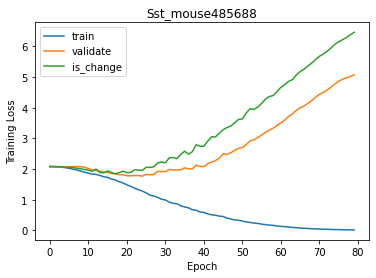

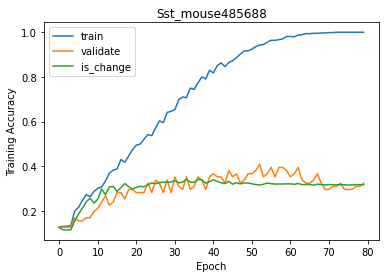

In [126]:
# Evaluate
net.eval()

plt.figure()
plt.title(fn)
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
# lossdf = pd.DataFrame({'training':training_losses,
#               'validation':validation_losses,
#               'is_change':out_losses})
plt.plot(training_losses,label='train')
plt.plot(validation_losses,label='validate')
plt.plot(out_losses,label='is_change')
plt.legend()

plt.figure()
plt.title(fn)
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
# lossdf = pd.DataFrame({'training':training_losses,
#               'validation':validation_losses,
#               'is_change':out_losses})
plt.plot(training_accs,label='train')
plt.plot(validation_accs,label='validate')
plt.plot(out_accs,label='is_change')
plt.legend()

yhat_train = net(X_train).to('cpu')
_, yhat_train = torch.max(yhat_train, 1)
score_train[mouse_id] = accuracy_score(y_train.to('cpu'), yhat_train)
print(f'Training score: {score_train[mouse_id]}')

yhat_test = net(X_test).to('cpu')
_, yhat_test = torch.max(yhat_test, 1)
score_test[mouse_id] = accuracy_score(y_test.to('cpu'), yhat_test)
print(f'Test score: {score_test[mouse_id]}')

yhat_out = net(X2).to('cpu')
_, yhat_out = torch.max(yhat_out, 1)
score_out[mouse_id] = accuracy_score(y2.to('cpu'), yhat_out)
print(f'Out score: {score_out[mouse_id]}')